# Custom Models

The goal of this notebook is to show the user how to build their own application-dependant model. To do so we will consider a univariate stochastic volatility model:

$y_t = \epsilon_t \exp\big(\frac{h_t}{2}\big), \quad \epsilon_t \sim \mathcal{N}(0,1)$

$h_{t+1} = \mu(1 − \phi) + \phi h_t + \sigma_\eta \eta_t, \quad \eta_t \sim \mathcal{N}(0,1)$, $t = 1,..., T,$

$h_0 \sim \mathcal{N}\big(0, \frac{\sigma^2_η}{(1 − \phi^2)}\big)$

## Imports

First thing first: let's import what we'll be needing.

In [1]:
import sys
sys.path.append("../..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# tensorflow imports
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
# filterflow model imports
from filterflow import SMC, State
from filterflow.observation import ObservationModelBase
from filterflow.proposal import BootstrapProposalModel
from filterflow.transition import RandomWalkModel

### The Model

The transition model can be encoded by adding a location to the normal distribution:

In [109]:
dx = 1
mu = tf.constant(-2.)
phi = tf.constant(0.2)
sigma_x = 0.1 * tf.ones(dx)

noise_rv = tfd.MultivariateNormalDiag(mu*(1-phi), sigma_x)
transition_matrix = phi * tf.eye(dx)

transition_model = RandomWalkModel(transition_matrix, noise_rv)

The Observation model however is a bit more complicated and you'll have to code it yourself, hopefully, this is done in a few lines of code:

ObservationModelBase is a base class that only has a loglikelihood method

In [110]:
ObservationModelBase.loglikelihood?

Signature:
ObservationModelBase.loglikelihood(
    self,
    state: filterflow.base.State,
    observation: tensorflow.python.framework.ops.Tensor,
)
Docstring:
Computes the loglikelihood of an observation given proposed particles
:param state: State
    Proposed (predicted) state of the filter given State at t-1 and Observation
:param observation: tf.Tensor
    User/Process given observation
:return: a tensor of loglikelihoods for all particles
:rtype: tf.Tensor
File:      
Type:      function


In [111]:
class StochVolObservationModel(ObservationModelBase):
    def __init__(self, observation_error, name='StochVolObservationModel'):
        super(StochVolObservationModel, self).__init__(name=name)
        self._observation_error = observation_error
        
    def _get_distribution(self, exp_particles):
        scale = tfp.bijectors.Scale(exp_particles)
        return tfd.TransformedDistribution(self._observation_error, scale)
        
    def loglikelihood(self, state, observation):
        # To simplify our work, let's simply use the tfp.bijectors utilities:
        exp_particles = tf.exp(state.particles / 2.)
        dist = self._get_distribution(exp_particles)
        return dist.log_prob(observation)

In [112]:
dy = 1
sigma_y = 0.1 * tf.ones(dx)
error_rv = tfd.MultivariateNormalDiag(scale_diag=sigma_y)

observation_model = StochVolObservationModel(error_rv)

### Let's test it

First get some data:

In [113]:
import quandl

In [114]:
API_KEY = ""

You can visit https://www.quandl.com/ to get your own API key

In [115]:
start_date = "2019-06-01"
end_date = "2020-01-01"

In [116]:
quandl.ApiConfig.api_key = API_KEY
d = quandl.get("ECB/EURUSD", start_date=start_date, end_date=end_date)

In [117]:
d.head()

,Value
Date,
2019-06-03,1.1185
2019-06-04,1.1244
2019-06-05,1.1257
2019-06-06,1.1266
2019-06-07,1.1273


Now take the log-returns:

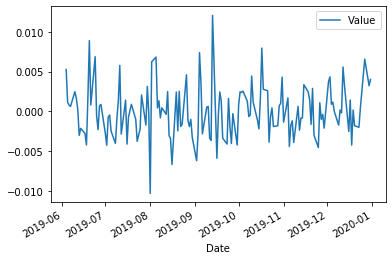

In [118]:
logreturns = np.log(d).diff().dropna()
logreturns.plot()

In [119]:
y = logreturns.values.astype(np.float32)

### We can now build our filter:

In [120]:
# filterflow resampling imports
from filterflow.resampling import NeffCriterion, StratifiedResampler, RegularisedTransform

In [121]:
proposal_model = BootstrapProposalModel(transition_model)
criterion = NeffCriterion(0.5, is_relative=True)
resampler = StratifiedResampler()
regularized_resampler = RegularisedTransform(0.25)
smc = SMC(observation_model, transition_model, proposal_model, criterion, resampler)
regularized_smc = SMC(observation_model, transition_model, proposal_model, criterion, regularized_resampler)

In [122]:
batch_size = 1
n_particles = 100
initial_state = State(np.random.normal(mu, sigma_x ** 2 / (1 - phi ** 2), [batch_size, n_particles, dx]).astype(np.float32))
observations_dataset = tf.data.Dataset.from_tensor_slices(y)

In [123]:
filtered_states = smc(initial_state, observations_dataset, n_observations=len(y), return_final=False, seed=111)
filtered_states_regularized = regularized_smc(initial_state, observations_dataset, n_observations=len(y), return_final=False, seed=111)

In [124]:
from filterflow.utils import mean, std
weighted_average = mean(filtered_states)
weighted_std = std(filtered_states, weighted_average)

weighted_average = weighted_average.numpy().squeeze()
weighted_std = weighted_std.numpy().squeeze()

weighted_average_regularized = mean(filtered_states_regularized)
weighted_std_regularized = std(filtered_states_regularized, weighted_average_regularized)

weighted_average_regularized = weighted_average_regularized.numpy().squeeze()
weighted_std_regularized = weighted_std_regularized.numpy().squeeze()

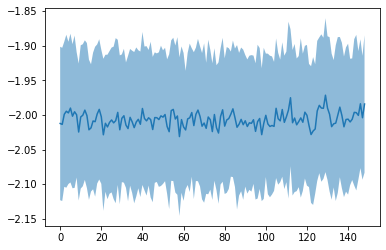

In [125]:
linespace = np.arange(0, len(y))
plt.plot(linespace, weighted_average)
plt.fill_between(linespace, weighted_average - weighted_std, weighted_average + weighted_std, alpha = 0.5)

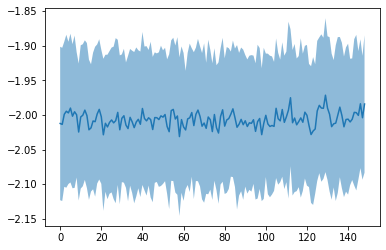

In [126]:
linespace = np.arange(0, len(y))
plt.plot(linespace, weighted_average_regularized)
plt.fill_between(linespace, weighted_average_regularized - weighted_std_regularized, weighted_average_regularized + weighted_std_regularized, alpha = 0.5)